# 1. 개요 
개요 및 import와 변수 등에 대한 설정 부분

In [42]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16, DenseNet201
from keras import models
from keras import layers
from keras import optimizers
from enum import Enum

In [2]:
print('케라스 버전 : {}'.format(keras.__version__))
print('텐서플로 버전 : {}'.format(tf.__version__))

케라스 버전 : 2.4.0
텐서플로 버전 : 2.3.0


In [20]:
# 테스트할 모델 유형을 enum 타입으로 정리.
class ModelType(Enum):
    ALL = 0
    CNN = 1
    VGG16 = 2
    DENSENET201 = 3

In [22]:
# 코드변수들 설정 (코드의 IF 문 같은데서 이용하는 목적임. 훈련,학습과는 관계없음)
IMAGE_UNZIP_WITH_COPY = False

# 검증용, 테스트용 비율
VALID_FILE_RATE = 0.2  # 검증용 파일 비율
TEST_FILE_RATE = 0.2  # 테스트용 파일 비율

# 이미지 가로,세로
IMAGE_WIDTH=150
IMAGE_HEIGHT=150

# 사용할 모델 유형 지정.
MODEL_TYPE = ModelType.DENSENET201

# 2. 이미지 데이터셋 의 처리

캐글의 이미지 데이터셋의 압축을 해제하고, 폴더 별로 구성합니다. 

`ImageDataGenerator`를 이용하기 위해서는 train, valid(validation)으로 나눌 필요가 있습니다. ImageDataGenerator의 'validation_split'을 이용할 경우에는 나누지 않아도 됩니다. (단지 이 경우에는 검증값도 이미지가 변형될 수 있음에 주의)

## 2.1. 압축 해제

1. 최상위 디렉토리 생성. 'train' 디렉토리 생성.
2. `extract`에 원본 소스 이미지 압축 풀기
  - `/input/dogs-vs-cats/` 의 'train.zip'파일을 `/output/kaggle/working/extract` 으로 압축해제 합니다.

In [5]:
# zip 으로 묶여있는 이미지셋 압축 해제
if IMAGE_UNZIP_WITH_COPY : 
    # 폴더가 이미 존재할 경우에는 삭제 후 다시 압축 해제 (그냥 혹시 몰라서 넣는 코드)
    if os.path.exists('./extract'):
        shutil.rmtree('./extract')

    # train.zip압축 해제 (/input/dogs-vs-cats/train.zip)(/output/kaggle/working/train/extract)
    with zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r') as zip_ref:
        zip_ref.extractall("./extract")
        
    # test1.zip압축 해제 (/output/kaggle/working)
    #with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r') as zip_ref:
    #    zip_ref.extractall("./")

In [6]:
# 디렉토리 경로 등을 설정할 변수
dirs = {}
dirs['extract_train'] = './extract/train'
dirs['base'] = './train'

In [8]:
print("전체 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f))])))

print("고양이 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f)) and 'cat' in f])))

print("강아지 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f)) and 'dog' in f])))

전체 이미지 수 : 25000
고양이 이미지 수 : 12500
강아지 이미지 수 : 12500


## 2.2. 학습, 검증 등을 위한 폴더 생성

In [9]:
# 기본이 될 디렉토리
base_dir = dirs['base']
if IMAGE_UNZIP_WITH_COPY : 
    if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
        shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
    os.mkdir(base_dir)

# 훈련, 검증, 테스트 를 위한 디렉토리
train_dir = os.path.join(base_dir, 'train')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(train_dir)
valid_dir = os.path.join(base_dir, 'valid')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(valid_dir)
test_dir = os.path.join(base_dir, 'test')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(test_dir)

# 훈련용 cats, dogs 디렉토리
train_cats_dir = os.path.join(train_dir, 'cats')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(train_dogs_dir)

# 검증용 cats, dogs 디렉토리
valid_cats_dir = os.path.join(valid_dir, 'cats')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(valid_cats_dir)
valid_dogs_dir = os.path.join(valid_dir, 'dogs')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(valid_dogs_dir)

# 테스트용 cats, dogs 디렉토리
test_cats_dir = os.path.join(test_dir, 'cats')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
if IMAGE_UNZIP_WITH_COPY : 
    os.mkdir(test_dogs_dir)

## 2.3. 애매한 이미지 파일 제거
이 쯤에서 애매하거나 불필요한 이미지파일들은 제거.
1. 고양이도 개도 아닌 사진
2. 사진이 아닌 그림, 삽화
3. 개와 고양이가 둘 다 있는 사진 제외 (학습시 안 좋을 듯 해서 제외)
4. 등만 보인다거나 배만 보인다거나 하는 경우 제외
5. 신생아 수준의 사진

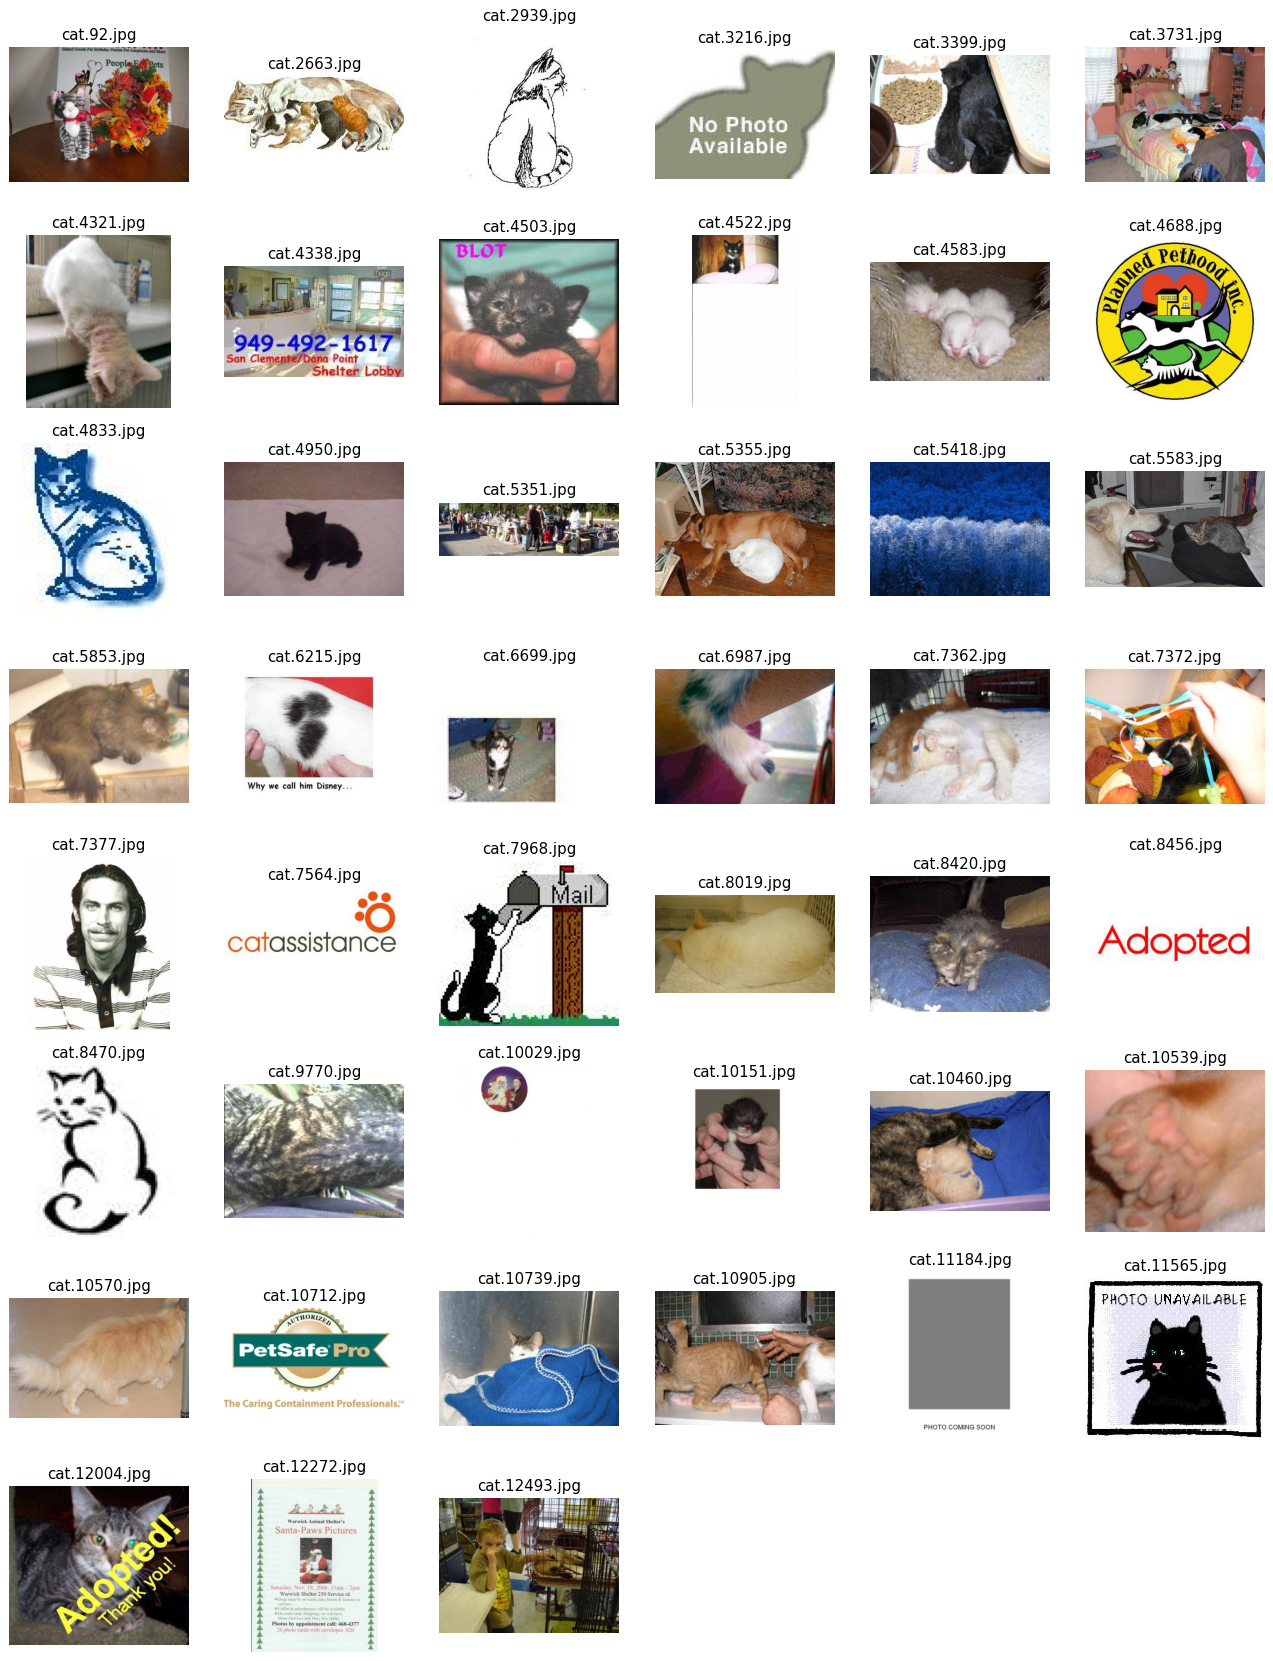

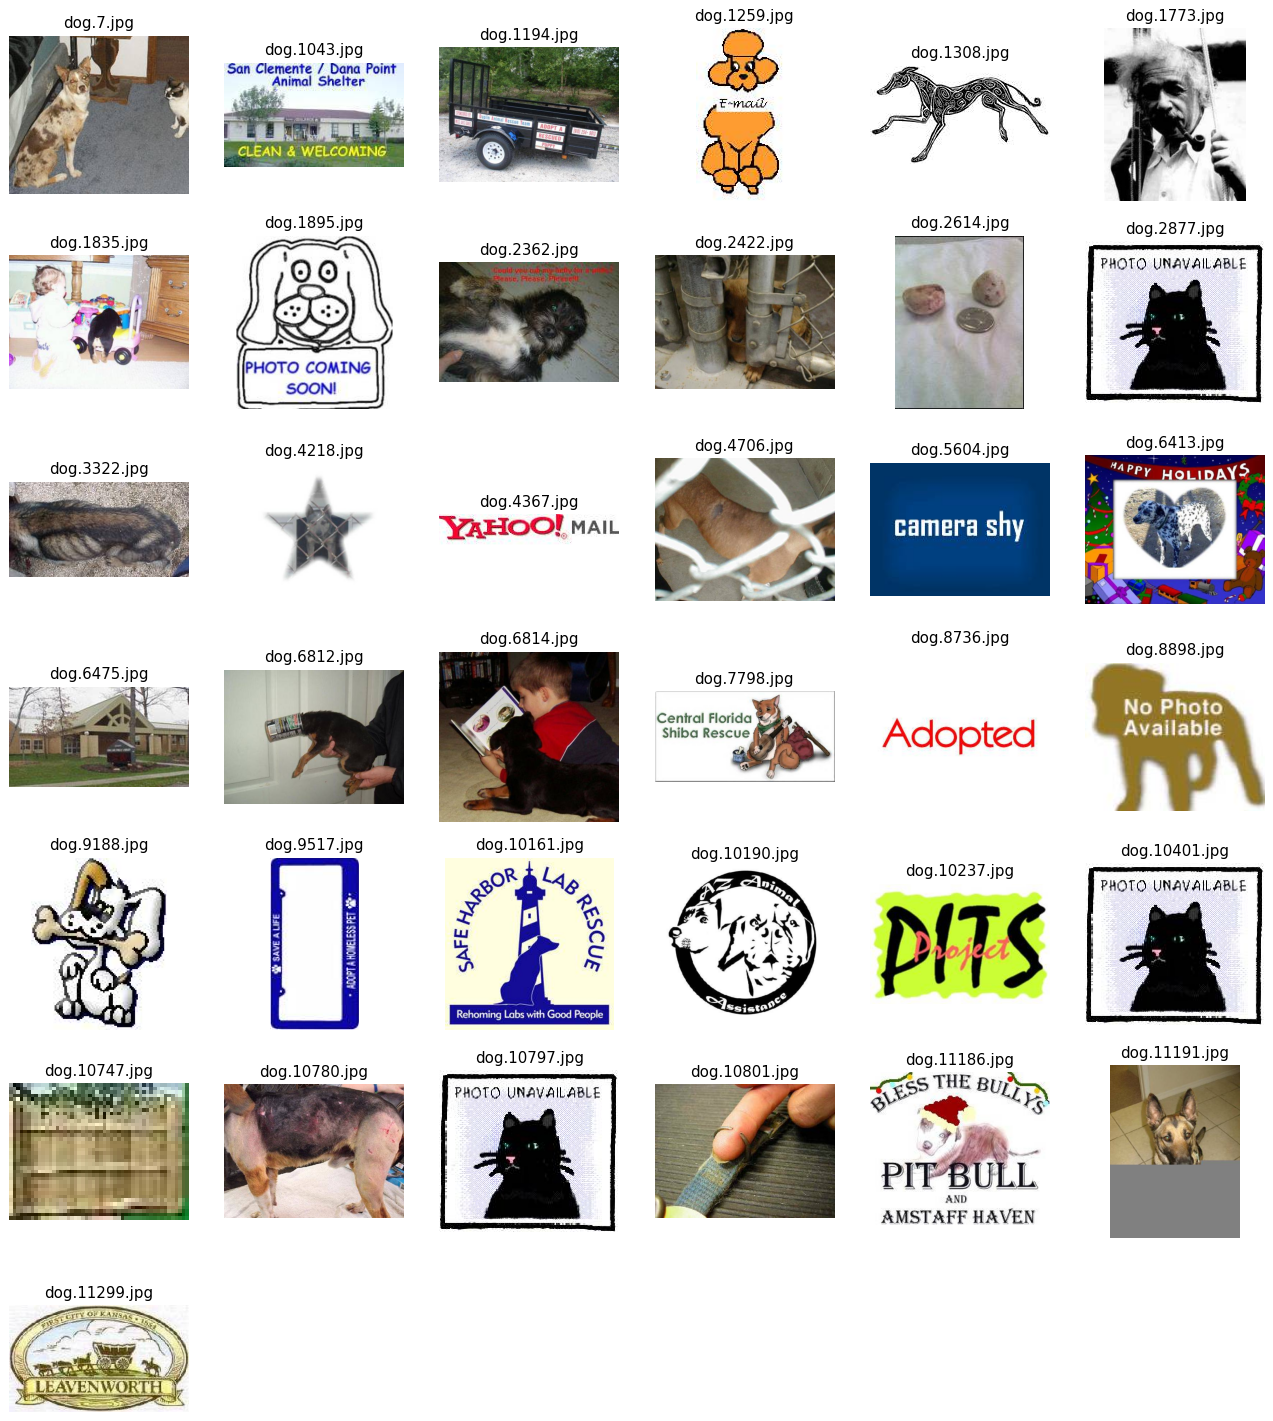

In [10]:
bad_cat_ids = [92, 2663, 2939, 3216, 3399, 3731, 4321, 4338, 4503, 4522, 4583, 4688, 4833, 4950,
               5351, 5355, 5418, 5583, 5853, 6215, 6699, 6987, 7362, 7372, 7377, 7564, 7968, 8019, 8420, 8456,
               8470, 9770, 10029, 10151, 10460, 10539, 10570, 10712, 10739, 10905, 11184, 
               11565, 12004, 12272, 12493]

bad_dog_ids = [7, 1043, 1194, 1259, 1308, 1773, 1835, 1895, 2362, 2422,
               2614, 2877, 3322, 4218, 4367, 4706, 5604, 6413, 6475, 6812, 6814,
               7798, 8736, 8898, 9188, 9517, 
               10161, 10190, 10237, 10401, 10747, 10780,
               10797, 10801, 11186, 11191, 11299]

# 이미지 화면에서 확인하기
def plot_images(cate, ids):
    ncols, nrows = 6, 10
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    
    for i, img_id in enumerate(ids):
        dirname = './extract/train/'
        filename = '{}.{}.jpg'.format(cate,img_id)
        img = plt.imread(os.path.join(dirname, filename))
        
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.title(str(filename))
        plt.axis('off')


if IMAGE_UNZIP_WITH_COPY : 
    bad_cats = plot_images('cat', bad_cat_ids)
    bad_dogs = plot_images('dog', bad_dog_ids)

In [11]:
# 제거의 기능을 담당하는 함수
def cleanup(cate, ids):
    oldpwd = os.getcwd()
   
    trash_dir = os.path.join(dirs['extract_train'], 'trash')
    if not os.path.exists(trash_dir):
        os.mkdir(trash_dir)
    
    for id in ids:
        filename = '{cate}.{id}.jpg'.format(cate=cate,id=id)
        src = os.path.join(dirs['extract_train'], filename)
        shutil.move(src, trash_dir)

# 제거 실행
if IMAGE_UNZIP_WITH_COPY : 
    cleanup('cat', bad_cat_ids)
    cleanup('dog', bad_dog_ids)

## 2.4. 각 폴더별로 이미지 나눠서 복사
각각 train, validation, test 폴더로 나눠서 구성한다. 
전체 이미지의 갯수는 25,000이고, 고양이 강아지 각각 반으로 나누면 12,500 개씩 있을 것이고. 60%, 20%, 20% 으로 구성한다면. (참고 https://ebbnflow.tistory.com/125)

예상치 (빠진 것들이 있으므로 이보다 적음)
* train - 7,500
* validation - 2,500
* test - 2,500 

In [12]:
# 비율별로 갯수를 계산
cat_count_total = 12500
dog_count_total = 12500

cat_count_valid = int(cat_count_total * VALID_FILE_RATE)
cat_count_test = int(cat_count_total * TEST_FILE_RATE)
cat_count_train = cat_count_total - cat_count_valid - cat_count_test

dog_count_valid = int(dog_count_total * VALID_FILE_RATE)
dog_count_test = int(dog_count_total * TEST_FILE_RATE)
dog_count_train = dog_count_total - dog_count_valid - dog_count_test

print("cats : total {} / train {} / valid {} / test {}".format(cat_count_total, cat_count_train, cat_count_valid, cat_count_test))
print("dogs : total {} / train {} / valid {} / test {}".format(dog_count_total, dog_count_train, dog_count_valid, dog_count_test))

cats : total 12500 / train 7500 / valid 2500 / test 2500
dogs : total 12500 / train 7500 / valid 2500 / test 2500


In [13]:
# 복사 실행
origin_dir = dirs['extract_train']

# 파일명으로 구분하여 복사를 실행하는 함수
def partialCopyImages(cate, start, end, origin, dest) :
    files = ['{}.{}.jpg'.format(cate, i) for i in range(start, end)]
    for filename in files:
        src = os.path.join(origin, filename)
        dst = os.path.join(dest, filename)
        if IMAGE_UNZIP_WITH_COPY : 
            if os.path.isfile(src):
                shutil.copyfile(src, dst)

# 고양이 [학습용, 검증용, 테스트용] 복사
partialCopyImages('cat', 0, cat_count_train, origin_dir, train_cats_dir)
partialCopyImages('cat', cat_count_train, cat_count_train+cat_count_valid, origin_dir, valid_cats_dir)
partialCopyImages('cat', cat_count_train+cat_count_valid, cat_count_total, origin_dir, test_cats_dir)

# 강아지 [학습용, 검증용, 테스트용] 복사
partialCopyImages('dog', 0, dog_count_train, origin_dir, train_dogs_dir)
partialCopyImages('dog', dog_count_train, dog_count_train+dog_count_valid, origin_dir, valid_dogs_dir)
partialCopyImages('dog', dog_count_train+dog_count_valid, dog_count_total, origin_dir, test_dogs_dir)

In [14]:
# 결과 확인
print('고양이 이미지 [학습용]: ', len(os.listdir(train_cats_dir)))
print('고양이 이미지 [검증용]: ', len(os.listdir(valid_cats_dir)))
print('고양이 이미지 [테스트용] ', len(os.listdir(test_cats_dir)))
print('--------------------------------')
print('강아지 이미지 [학습용] ', len(os.listdir(train_dogs_dir)))
print('강아지 이미지 [검증용] ', len(os.listdir(valid_dogs_dir)))
print('강앙지 이미지 [테스트용] ', len(os.listdir(test_dogs_dir)))

고양이 이미지 [학습용]:  7475
고양이 이미지 [검증용]:  2493
고양이 이미지 [테스트용]  2487
--------------------------------
강아지 이미지 [학습용]  7479
강아지 이미지 [검증용]  2495
강앙지 이미지 [테스트용]  2489


# 3. 모델 종류별

# 3.1. CNN 모델
간단히 작성한 CNN 모델로 어떤 성능을 나타내는지 확인해보자.

## 3.1.1. 데이터 전처리 (CNN)

In [15]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

    # ------------------------
    # 데이터 형태 확인
    # ------------------------
    for data_batch, labels_batch in train_generator:
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break;

## 3.1.2. 모델 생성 (CNN)

In [16]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

## 3.1.3. 모델 학습 (CNN)

In [17]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adamax(lr=0.001),
             metrics=['acc'])
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        validation_steps=50,
        epochs = 15
    )

## 3.1.4. 모델 저장 (CNN)

In [18]:
# 모델 파일 저장하기.
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model.save('cats_vs_dogs_cnn.h5')

# 3.2. VGG16 모델
vgg16 모델을 이용한 테스트

## 3.2.1. 데이터 전처리 (VGG16)

In [ ]:
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

## 3.2.2. 모델 생성 (VGG16)

In [ ]:
# VGG Model
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    # conv_base.summary()
    conv_base.trainable = False

    model_vgg = models.Sequential()
    model_vgg.add(conv_base)
    model_vgg.add(layers.Flatten())
    model_vgg.add(layers.Dense(256, activation='relu'))
    model_vgg.add(layers.Dense(1, activation='sigmoid'))
    model_vgg.summary()

## 3.2.3. 모델 학습 (VGG16)

In [ ]:
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    # 컴파일
    model_vgg.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])
    
    # callback 관련
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='acc',
            patience=1),
        keras.callbacks.ModelCheckpoint(
            filepath='cats_vs_dogs_vgg16.h5',
            monitor='loss',
            svae_best_only=True)
    ]

    # 학습 시작
    history = model_vgg.fit(
        train_generator,
        steps_per_epoch=15,
        validation_data=valid_generator,
        validation_steps=50,    
        epochs = 10,
        callbacks = callbacks_list)

# DenseNet201

In [28]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

    # ------------------------
    # 데이터 형태 확인
    # ------------------------
    for data_batch, labels_batch in train_generator:
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break;

Found 14954 images belonging to 2 classes.
Found 4988 images belonging to 2 classes.
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


In [40]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    conv_base = DenseNet201(
                    weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                    pooling='avg')

    conv_base.trainable = False

    model_densenet201 = models.Sequential()
    model_densenet201.add(conv_base)
    # model_densenet201.add(layers.Flatten())
    model_densenet201.add(layers.Dense(128, activation='relu'))
    model_densenet201.add(layers.Dense(128, activation='relu'))
    model_densenet201.add(layers.Dense(1, activation='sigmoid'))
    model_densenet201.summary()
    
    
    # model_densenet201.compile(
    #    loss='binary_crossentropy',
    #    optimizer='adam',
    #    metrics=['accuracy']
    #)
    model_densenet201.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adamax(lr=0.001),
             metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_14 (Dense)             (None, 128)               245888    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 18,584,513
Trainable params: 262,529
Non-trainable params: 18,321,984
_________________________________________________________________


In [41]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    history = model_densenet201.fit(
        train_generator,
        validation_data=valid_generator,
        epochs = 15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)]
    )

Epoch 1/15
 15/748 [..............................] - ETA: 12:12 - loss: 7.1163 - accuracy: 0.5333

KeyboardInterrupt: 